In [182]:
import statsmodels.api as sm 
import sqlite3
import pickle
import codecs
import otree
import binascii
import os,sys
import math

module_path = os.path.abspath(os.path.join('../../../tau_thesis_tools/'))

module_path = os.path.abspath(os.path.join('../otree-halluc/'))

if module_path not in sys.path:
    sys.path.append(module_path)
from otree import settings

In [183]:
figs_folder="/Users/olivierkamoun/Library/Mobile Documents/com~apple~CloudDocs/study/TAU_cyber/thesis/figs_arch/us_"
def save_plot(name_plot,aplot=None):
    if aplot is None :
        aplot=plt
    
    plt.savefig(figs_folder+name_plot+'.png', format="png", bbox_inches="tight")

In [184]:
import pandas as pd
from ydata_profiling import ProfileReport

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline
from sklearn.linear_model import LinearRegression
import logging
import seaborn as sns
from data_analysis import OtreeCleaning

# General settings

In [185]:
sns.set(style="whitegrid")

In [186]:
default_temo = 0.7

## tools

In [187]:
def clean_to_str(c):

    if isinstance(c,str) or pd.isna(c):
        return c
    else :
        return str(int(c))

#  load data

### load from database bot results

In [188]:
sql_string = "/Users/olivierkamoun/PycharmProjects/otree_projects_thesis/hallucinations/otree-halluc/db.sqlite3"

In [189]:
sessions_dict= {
                '27sypexp':'dialog GPT3',
                'til5ljad':'html GPT3',
                'a3ni6rrc':'dialog GPT4',
                'pvsds87k':'html GPT4'}
sessions_clean = list(sessions_dict.keys())



### Define list of sessions to analyse

In [190]:
sessions= list(sessions_dict.keys())
otc=OtreeCleaning(session_configs=sessions,sql_string=sql_string )
sessions_df,df =otc.load_sql()
print(f' loaded {len(df)} run for {len(sessions_df)} sessions ')

 loaded 200 run for 4 sessions 


In [191]:
sessions_df

,id,_vars,config,label,mturk_HITId,mturk_HITGroupId,is_mturk,mturk_use_sandbox,mturk_expiration,mturk_qual_id,...,is_demo,_admin_report_app_names,_admin_report_num_rounds,num_participants,_created,config_dict,config_name,default_engine_param,temperature,long_name
code,,,,,,,,,,,,,,,,,,,,,
til5ljad,77,gAR9lC4=\n,gASVfgEAAAAAAAB9lCiMHXJlYWxfd29ybGRfY3VycmVuY3...,,None,None,0,1,None,,...,0,,,50,1.718526e+09,"{'real_world_currency_per_point': 1.0, 'partic...",us_profile_html,{},0.7,us_profile_html_50
27sypexp,78,gAR9lC4=\n,gASVggEAAAAAAAB9lCiMHXJlYWxfd29ybGRfY3VycmVuY3...,,None,None,0,1,None,,...,0,,,50,1.718526e+09,"{'real_world_currency_per_point': 1.0, 'partic...",us_profile_dialog,{},0.7,us_profile_dialog_50
a3ni6rrc,83,gAR9lC4=\n,gASVuQEAAAAAAAB9lCiMHXJlYWxfd29ybGRfY3VycmVuY3...,,None,None,0,1,None,,...,0,,,50,1.718613e+09,"{'real_world_currency_per_point': 1.0, 'partic...",us_profile_dialog_gpt4,"{'model': 'gpt-4o', 'n': 2}",0.7,us_profile_dialog_gpt4_50
pvsds87k,85,gAR9lC4=\n,gASVtQEAAAAAAAB9lCiMHXJlYWxfd29ybGRfY3VycmVuY3...,,None,None,0,1,None,,...,0,,,50,1.718616e+09,"{'real_world_currency_per_point': 1.0, 'partic...",us_profile_html_gpt4,"{'model': 'gpt-4o', 'n': 2}",0.7,us_profile_html_gpt4_50


In [192]:


df=otc.categories_to_numeric()


In [193]:
item_col=list(df.columns)
len(item_col)

85

In [194]:
df['full']=df['_max_page_index']<=df['_index_in_pages']
df['session.code']=df['_session_code']
df=df.sort_values("_created")

In [195]:
df[['_session_code','full','_created']].groupby("_session_code").mean().sort_values('_created').style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) 

,FULL,_CREATED
_session_code,,
til5ljad,"0,820","1.718.525.682,553"
27sypexp,"0,980","1.718.525.919,855"
a3ni6rrc,"1,000","1.718.612.911,523"
pvsds87k,"1,000","1.718.615.986,081"


In [196]:
df['last_page'] = [f"{v[0]}_{v[1]}"  for i,v in df[['_index_in_pages','_current_page_name']].iterrows() ]
page_anal=pd.crosstab(values=df['_is_bot'],index=df['_session_code'],columns=df['last_page'],aggfunc='count',normalize='index')

page_anal=page_anal.fillna(0)

# use time sort :
page_anal = page_anal.loc[sessions_df.index]

In [197]:
def nice_session_label(s):
    if s in sessions_dict :
        if '_' in sessions_dict[s]:
            return ' '.join(sessions_dict[s].split('_')[1:])
        else :
            return sessions_dict[s]
    return s


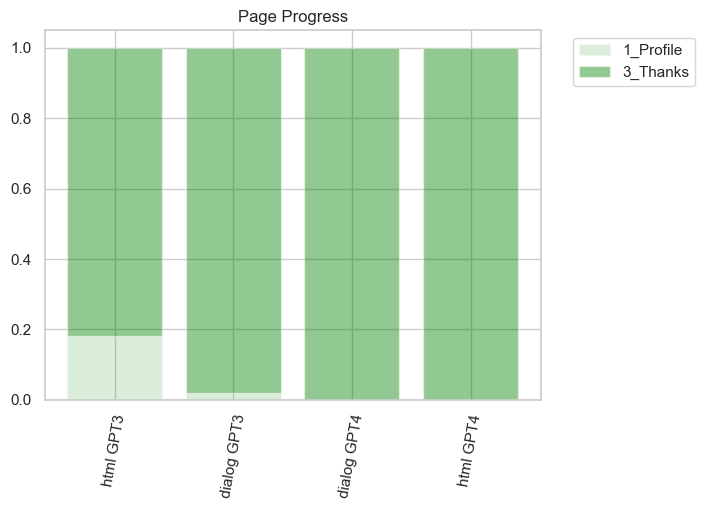

In [198]:
bottom=[]
def alpha_p (p):
    return int(p.split('_')[0])/7
for p in page_anal.columns:
    if len(bottom) == 0 :
        plt.bar(page_anal.index, page_anal[p], label=p, alpha=alpha_p(p),color='green')
        bottom=page_anal[p]
    else:
        plt.bar(page_anal.index, page_anal[p], bottom = bottom , label=p,alpha=alpha_p(p),color='green')
        bottom=page_anal[p] + bottom
        

x_lab=[nice_session_label(l) for l in page_anal.index]
x_pos= np.arange(len(page_anal))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Page Progress')
plt.xticks(x_pos, x_lab ,rotation=80)
plt.savefig(figs_folder+"page_progess.png", format="png", bbox_inches="tight")
plt.show()

## Load original data

In [199]:


file_ref_profile="/Users/olivierkamoun/PycharmProjects/tau_thesis_tools/us_court_survey/us_survey_raw_70.csv"

In [200]:
#get profile file per session
sessions_df['profile_file']=[ c.get('profile_file',file_ref_profile) for c in sessions_df['config_dict']]


In [201]:
session_participant_dict={}
case_id_list=[]
distinct_original={}
for s in sessions_df.index:
    fn =  sessions_df.loc[s]['profile_file']
    ref_profile_df=pd.read_csv(fn)
    ref_profile_df['age']=2020-ref_profile_df['birthyr']
    p_list= df[df['session.code']==s][['code_2','id_in_session'] ].to_dict(orient='index')
    c_list = ref_profile_df['caseid'][:len(p_list)]
    s_dict={p['code_2']:ref_profile_df['caseid'][p['id_in_session']-1]  for i,p in p_list.items()}
    session_participant_dict[s]=s_dict
    case_id_list = case_id_list + list(c_list)
    name = f'original {len(c_list)}'
    k= fn+name 
    if k not in distinct_original :
        distinct_original[k]={'len':len(c_list),'name':name,'caseis_list':list(c_list) }
        print (distinct_original[k])

        

{'len': 50, 'name': 'original 50', 'caseis_list': [1032326091, 1030827483, 1039977991, 1032308637, 1031879237, 1030417127, 1037784917, 1029951241, 1041003959, 1037672619, 1030205683, 1041006215, 1037446177, 1036448329, 1039357173, 1031568835, 1036726049, 1038581481, 1028831691, 1031929901, 1031327491, 1033707299, 1038030043, 1033981091, 1041007253, 1044119551, 1030536363, 1039978277, 1030537507, 1035342335, 1030954519, 1030716477, 1031812799, 1031135725, 1030096585, 1041014977, 1041015677, 1037126459, 1037329677, 1037446463, 1030506599, 1037328839, 1031410283, 1039978109, 1030960163, 1031063343, 1037302877, 1030537039, 1041006203, 1034921987]}


In [202]:
file_raw_original="/Users/olivierkamoun/PycharmProjects/tau_thesis_tools/us_court_survey/full_survey_label_shuffled.csv"
raw_original_df=pd.read_csv(file_raw_original)
raw_original_df['age']=2020-raw_original_df['birthyr']
distinct_original['original']={'len':len(raw_original_df),'name':'original','caseis_list':list(raw_original_df['caseid']) }

In [203]:
raw_original_df_selected=raw_original_df.set_index('caseid').loc[case_id_list].reset_index()

In [204]:

match_columns_file="/Users/olivierkamoun/PycharmProjects/tau_thesis_tools/us_court_survey/match_columns_label.csv"
match_columns_df=pd.read_csv(match_columns_file)
match_columns_dict=match_columns_df.set_index('col_ref').to_dict(orient='index')


### Reform original data into new bot format

In [205]:
item_ref_dict=raw_original_df[['caseid']+list(match_columns_df['col_ref'])].to_dict()


In [206]:
item_ref_dict.keys()

dict_keys(['caseid', 'IUA159', 'IUA160', 'IUA158', 'IUA157', 'IUA155a', 'IUA155b', 'IUA155c', 'IUA155d', 'IUA155e', 'IUA155f', 'IUA156a', 'IUA156b', 'IUA156c', 'IUA156d', 'IUA156e', 'IUA156f', 'IUA154a', 'IUA154b', 'IUA153a', 'IUA153b', 'age', 'religpew', 'CC19_313', 'gender', 'educ', 'inputstate', 'ownhome'])

In [207]:

new_data={'caseid':item_ref_dict['caseid']}
new_data['influence_type']={}
for c in item_ref_dict:
    if c in match_columns_dict :
                newc = match_columns_dict[c]['col_new']
                if not(pd.isna(match_columns_dict[c]['future_past'] )):
                        tf_col = 'time_frame_'+match_columns_dict[c]['future_past'] 
                else :
                     tf_col=None
                if newc not in new_data: 
                    
                    new_data[newc]= {i:pd.NA for i in item_ref_dict[c]}
                    if tf_col is not None and tf_col not in new_data :
                             new_data[tf_col]={i:pd.NA for i in  item_ref_dict[c]}

                for i,v in item_ref_dict[c].items():
                    if not(pd.isna( v )) and v not in [9,99,98]:
                        if pd.isna(new_data[newc][i]) or new_data[newc][i]==0 or new_data[newc][i]==9 :
                            if tf_col is not None :
                                  new_data[tf_col][i]=match_columns_dict[c]['time_frame'] 
                                  if not(pd.isna(match_columns_dict[c]['criteria'] )) :
                                        new_data['influence_type'][i]= match_columns_dict[c]['criteria']
                            new_data[newc][i]=item_ref_dict[c][i]
                        else :
                            print(f"value conlict {i} {new_data[newc][i]} {item_ref_dict[c][i]}")
    else :
         print(f'{c} not in list')
original_df = pd.DataFrame.from_dict(new_data)




caseid not in list


In [208]:
original_df

,caseid,influence_type,change_selection_num,change_size_num,change_term_num,changes_num,future_influence_society_treated_num,time_frame_future,future_like_you_treated_num,influence_like_you_num,time_frame_past,influence_society_num,age,religion,political_aff,sex,educ,residence,ownhome
0,1032326091,H,Slightly support,Somewhat oppose,Somewhat support,Slightly oppose,Likely to be somewhat worse off,15.0,Likely to be somewhat worse off,Been hurt somewhat,15.0,Benefitted slightly,35,Agnostic,Democratic candidate,Male,Post-grad,California,Own
1,1030827483,B,Strongly support,Strongly oppose,Somewhat support,Strongly support,Likely to be slightly better off,15.0,Likely to be slightly better off,Not really influenced,15.0,Not really influenced,51,Nothing in particular,Republican candidate,Male,Some college,New Jersey,Own
2,1039977991,H,Somewhat support,Slightly support,Slightly oppose,Slightly support,<NA>,15.0,Likely to be slightly worse off,Benefitted slightly,15.0,Benefitted slightly,35,Roman Catholic,Democratic candidate,Female,2-year,Texas,Own
3,1032308637,B,Somewhat support,Somewhat support,Slightly oppose,Slightly support,Likely to be slightly better off,15.0,Likely to be slightly better off,Not really influenced,15.0,Not really influenced,34,Nothing in particular,Democratic candidate,Male,High school graduate,Michigan,Rent
4,1031879237,I,Slightly oppose,Slightly oppose,Slightly oppose,Somewhat support,Likely to be slightly better off,15.0,Likely to be slightly better off,Not really influenced,15.0,Benefitted slightly,38,Protestant,Republican candidate,Female,4-year,Nevada,Own
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1031632143,H,Strongly support,Strongly support,Strongly support,Strongly support,Likely to be substantially worse off,15.0,Likely to be substantially worse off,Been hurt somewhat,15.0,Been hurt a great deal,39,Agnostic,Democratic candidate,Female,4-year,New York,Rent
996,1031882705,I,Slightly oppose,Somewhat support,Somewhat support,Somewhat support,Likely to be slightly worse off,15.0,Likely to be slightly worse off,Been hurt slightly,15.0,Benefitted somewhat,38,Atheist,Democratic candidate,Male,4-year,Pennsylvania,Own
997,1031281847,I,Strongly support,Somewhat support,Slightly oppose,Somewhat support,Likely to be slightly worse off,75.0,Likely to be slightly worse off,Benefitted a great deal,75.0,Benefitted a great deal,45,Protestant,Democratic candidate,Female,4-year,North Carolina,Own
998,1030564051,H,Slightly oppose,Somewhat oppose,Somewhat support,Slightly oppose,Likely to be somewhat better off,75.0,Likely to be somewhat better off,Benefitted somewhat,75.0,Benefitted a great deal,56,Nothing in particular,Democratic candidate,Male,Post-grad,Washington,Other


In [209]:
num_cols =[c for c in item_col if '_num' in c and not(c.startswith('_'))] +['age']
num_cols

['round_number',
 'sex_num',
 'educ_num',
 'political_ide_num',
 'political_aff_num',
 'political_gov_sup_num',
 'religion_num',
 'next_election_num',
 'status_num',
 'ownhome_num',
 'age']

In [210]:
all_app=df
bot_and_orig_df =all_app
for orig_f in  distinct_original:
    sub_orig= original_df.set_index('caseid').loc[distinct_original[orig_f]['caseis_list']]
    sub_orig['session.code']=distinct_original[orig_f]['name']
    bot_and_orig_df= pd.concat([bot_and_orig_df,sub_orig],axis=0)

bot_and_orig_df['nice_session']=[nice_session_label(s) for s in bot_and_orig_df['session.code']]
sessions_and_orig_list = set(bot_and_orig_df['session.code'])

<Axes: xlabel='_session_code'>

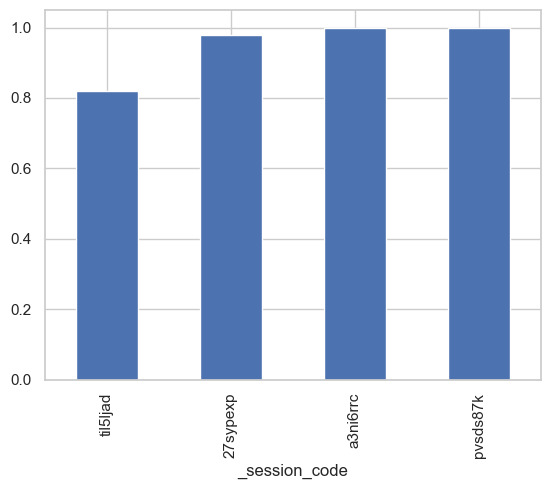

In [211]:
sum_mean=df.groupby("_session_code").mean(numeric_only=True).sort_values('_created')
sum_mean['full'].plot.bar()

In [212]:
item_col_cat = [c for c in item_col if 'open_ended' not in c and c not in ['court_decision']]
item_col_cat

['sex',
 'educ',
 'age',
 'race',
 'political_ide',
 'political_us_ide',
 'political_aff',
 'political_gov_sup',
 'religion',
 'non_jews_religiosity',
 'jews_religiosity',
 'next_election',
 'status',
 'profile_id',
 'residence',
 'ownhome',
 'round_number',
 'id_in_group',
 'id',
 '_vars',
 'config',
 'label',
 'code',
 'mturk_HITId',
 'mturk_HITGroupId',
 'is_mturk',
 'mturk_use_sandbox',
 'mturk_expiration',
 'mturk_qual_id',
 'archived',
 'comment',
 '_anonymous_code',
 'is_demo',
 '_admin_report_app_names',
 '_admin_report_num_rounds',
 'num_participants',
 '_created',
 'id_2',
 '_vars_2',
 'session_id',
 'label_2',
 'id_in_session',
 'payoff',
 'time_started_utc',
 'mturk_assignment_id',
 'mturk_worker_id',
 '_index_in_pages',
 '_monitor_note',
 'code_2',
 '_session_code',
 'visited',
 '_last_page_timestamp',
 '_last_request_timestamp',
 'is_on_wait_page',
 '_current_page_name',
 '_current_app_name',
 '_round_number',
 '_current_form_page_url',
 '_max_page_index',
 '_is_bot',
 'i

## other analyis

In [213]:
page_anal

last_page,1_Profile,3_Thanks
code,,
til5ljad,0.18,0.82
27sypexp,0.02,0.98
a3ni6rrc,0.00,1.00
pvsds87k,0.00,1.00


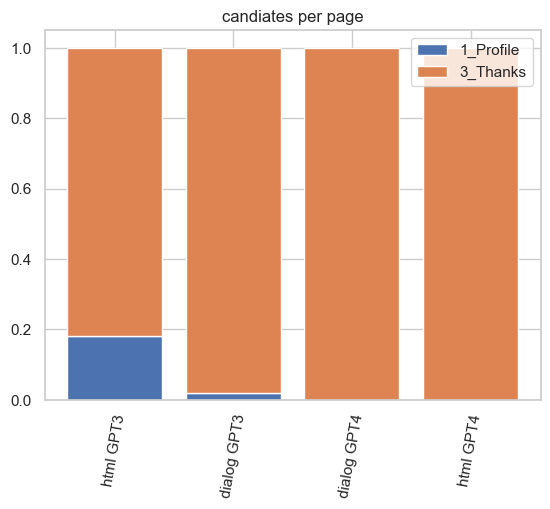

In [214]:
bottom=[]

for p in page_anal.columns:
    if len(bottom) == 0 :
        plt.bar(page_anal.index, page_anal[p], label=p)
        bottom=page_anal[p]
    else:
        plt.bar(page_anal.index, page_anal[p], bottom = bottom , label=p)
        bottom=page_anal[p] + bottom
        

x_lab=[nice_session_label(l) for l in page_anal.index]
x_pos= np.arange(len(page_anal))
plt.legend()
plt.title('candiates per page')
plt.xticks(x_pos, x_lab ,rotation=80)
plt.savefig(figs_folder+"tmp.png", format="png", bbox_inches="tight")
plt.show()

for s in sessions :
    file_rep_name= "/Users/olivierkamoun/PycharmProjects/tau_thesis_tools/court_survey/reports/bot"+s +".html"
    if os.path.exists(file_rep_name):
        print (f"report {file_rep_name} already exists ")
    else :
        print (f"generating reprot {file_rep_name}  ")
        #report = ProfileReport(all_app[all_app['session.code']==s][rev_cols])
        #hrep=report.to_file(file_rep_name)

In [215]:
def short_col_names(cols):
    new_cols=[]
    for i,n in enumerate(cols):
        if '_' in n:
            nn = ' '.join(n.split('_')[:-1])
        else :
            nn= n

        new_cols.append(str(i)+":"+nn)
    return new_cols
def color_map (cov_mat_df,interval=(-1,1),title="",ax=None):
    if ax is None :
        ax=plt
        use_plt=True
    else :
        use_plt=False
    
    ax.imshow(cov_mat_df,vmax=interval[1],vmin=interval[0], cmap='bwr')
   
    ax.grid(None)
    if use_plt:
        plt.title(title)
        plt.colorbar()
        plt.xticks(range(len(cov_mat_df.index)),short_col_names(cov_mat_df.index), rotation=90)
        plt.yticks(range(len(cov_mat_df.columns)),short_col_names(cov_mat_df.columns))
        plt.show()
        
    else :
        ax.set_title(title)
        
  




In [216]:
bot_and_orig_df['_is_bot'] = bot_and_orig_df['_is_bot'].fillna(0)

In [217]:
def clean_tab(data,f,cols):
    p_mat={}

    for cx in cols:
        p_matx={}
        for cy in cols:

                x= data[cx][(~pd.isna(data[cx]))&((~pd.isna(data[cy])))]
                y= data[cy][(~pd.isna(data[cx]))&((~pd.isna(data[cy])))]  
                
                p_tab = f(np.float64(x),np.float64(y))
                p_matx[cy]=p_tab
        p_mat[cx]=p_matx
    return pd.DataFrame.from_dict(p_mat)



## check profile data

In [218]:
original_df

,caseid,influence_type,change_selection_num,change_size_num,change_term_num,changes_num,future_influence_society_treated_num,time_frame_future,future_like_you_treated_num,influence_like_you_num,time_frame_past,influence_society_num,age,religion,political_aff,sex,educ,residence,ownhome
0,1032326091,H,Slightly support,Somewhat oppose,Somewhat support,Slightly oppose,Likely to be somewhat worse off,15.0,Likely to be somewhat worse off,Been hurt somewhat,15.0,Benefitted slightly,35,Agnostic,Democratic candidate,Male,Post-grad,California,Own
1,1030827483,B,Strongly support,Strongly oppose,Somewhat support,Strongly support,Likely to be slightly better off,15.0,Likely to be slightly better off,Not really influenced,15.0,Not really influenced,51,Nothing in particular,Republican candidate,Male,Some college,New Jersey,Own
2,1039977991,H,Somewhat support,Slightly support,Slightly oppose,Slightly support,<NA>,15.0,Likely to be slightly worse off,Benefitted slightly,15.0,Benefitted slightly,35,Roman Catholic,Democratic candidate,Female,2-year,Texas,Own
3,1032308637,B,Somewhat support,Somewhat support,Slightly oppose,Slightly support,Likely to be slightly better off,15.0,Likely to be slightly better off,Not really influenced,15.0,Not really influenced,34,Nothing in particular,Democratic candidate,Male,High school graduate,Michigan,Rent
4,1031879237,I,Slightly oppose,Slightly oppose,Slightly oppose,Somewhat support,Likely to be slightly better off,15.0,Likely to be slightly better off,Not really influenced,15.0,Benefitted slightly,38,Protestant,Republican candidate,Female,4-year,Nevada,Own
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1031632143,H,Strongly support,Strongly support,Strongly support,Strongly support,Likely to be substantially worse off,15.0,Likely to be substantially worse off,Been hurt somewhat,15.0,Been hurt a great deal,39,Agnostic,Democratic candidate,Female,4-year,New York,Rent
996,1031882705,I,Slightly oppose,Somewhat support,Somewhat support,Somewhat support,Likely to be slightly worse off,15.0,Likely to be slightly worse off,Been hurt slightly,15.0,Benefitted somewhat,38,Atheist,Democratic candidate,Male,4-year,Pennsylvania,Own
997,1031281847,I,Strongly support,Somewhat support,Slightly oppose,Somewhat support,Likely to be slightly worse off,75.0,Likely to be slightly worse off,Benefitted a great deal,75.0,Benefitted a great deal,45,Protestant,Democratic candidate,Female,4-year,North Carolina,Own
998,1030564051,H,Slightly oppose,Somewhat oppose,Somewhat support,Slightly oppose,Likely to be somewhat better off,75.0,Likely to be somewhat better off,Benefitted somewhat,75.0,Benefitted a great deal,56,Nothing in particular,Democratic candidate,Male,Post-grad,Washington,Other


In [219]:

col_prof = [ 'sex','age', 'educ', 'political_ide', 'religion',
       'political_aff',  'political_gov_sup', 'next_election', 
       'status',  'ownhome','residence']

res_all_col = {}
res_all_col_tabs=[]
decode_profile_col_dict={'educ':{'2-year':'3-Some college',
                                 '4-year':'4-College graduate','Post-grad':'5-Post graduate degree','No HS':'1-Did not finish high school',6:5},
                        'political_aff':{'I did not vote for US House in 2018':'4-didnt vote',"I don't recall":'5-I dont recall'}}


for i,l in all_app.iterrows()  :
        part_code = l['code_2']
        caseid = session_participant_dict[l['session.code']][part_code]
        l_orig = original_df[original_df['caseid']==caseid].iloc[0]
        for  c in col_prof :
            if c not in l_orig:
                continue
            orig_value = l_orig[c]
            if c in decode_profile_col_dict :
                orig_value = decode_profile_col_dict[c].get(orig_value,orig_value) 
            if not(c in res_all_col) :
                res_all_col[c]=dict()
            
            d=res_all_col[c]
            s= l['session.code'] 
            if s not in d :
                  d[s] = {'good': 0 , 'zero': 0, 'diff':0}
            if pd.isna(orig_value):
                print (f'null value for {c}')
                d[s]['zero'] += 1
                continue
            if l[c] == orig_value :
                d[s]['good'] += 1 
            elif  str(l[c]).split('-')[-1] == orig_value:
                d[s]['good'] += 1
            
            elif  l[c] == 0 or pd.isna(l[c]):
                d[s]['zero'] += 1
            else :
                  d[s]['diff']+=1
                  
            res_all_col[c] = d    
#                  d = {'good':sum(tab[s]==tab['orig_decode']), 'zero':sum(tab[s]==0), 'diff':sum(tab[s]!=tab['orig_decode']) - sum(tab[s]==0)}

pd.DataFrame.from_dict(res_all_col)

,sex,age,educ,religion,political_aff,ownhome,residence
til5ljad,"{'good': 40, 'zero': 9, 'diff': 1}","{'good': 41, 'zero': 9, 'diff': 0}","{'good': 41, 'zero': 9, 'diff': 0}","{'good': 41, 'zero': 9, 'diff': 0}","{'good': 40, 'zero': 9, 'diff': 1}","{'good': 41, 'zero': 9, 'diff': 0}","{'good': 40, 'zero': 9, 'diff': 1}"
27sypexp,"{'good': 49, 'zero': 1, 'diff': 0}","{'good': 49, 'zero': 1, 'diff': 0}","{'good': 49, 'zero': 1, 'diff': 0}","{'good': 49, 'zero': 1, 'diff': 0}","{'good': 49, 'zero': 1, 'diff': 0}","{'good': 49, 'zero': 1, 'diff': 0}","{'good': 49, 'zero': 1, 'diff': 0}"
a3ni6rrc,"{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 46, 'zero': 0, 'diff': 4}","{'good': 50, 'zero': 0, 'diff': 0}"
pvsds87k,"{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 50, 'zero': 0, 'diff': 0}","{'good': 46, 'zero': 0, 'diff': 4}","{'good': 50, 'zero': 0, 'diff': 0}"


In [220]:
pd.DataFrame.from_dict(res_all_col['educ']).transpose().to_html(figs_folder+'us_check_profile.html')

In [221]:
pd.DataFrame.from_dict(res_all_col['sex']) / pd.DataFrame.from_dict(res_all_col['sex']).sum()

,til5ljad,27sypexp,a3ni6rrc,pvsds87k
good,0.80,0.98,1.0,1.0
zero,0.18,0.02,0.0,0.0
diff,0.02,0.00,0.0,0.0


In [222]:
col_res=res_all_col['sex']

col_res

{'til5ljad': {'good': 40, 'zero': 9, 'diff': 1},
 '27sypexp': {'good': 49, 'zero': 1, 'diff': 0},
 'a3ni6rrc': {'good': 50, 'zero': 0, 'diff': 0},
 'pvsds87k': {'good': 50, 'zero': 0, 'diff': 0}}

In [223]:

col_res=res_all_col['sex']
pd.DataFrame.from_dict(res_all_col['sex']) / pd.DataFrame.from_dict(res_all_col['sex']).sum()

,til5ljad,27sypexp,a3ni6rrc,pvsds87k
good,0.80,0.98,1.0,1.0
zero,0.18,0.02,0.0,0.0
diff,0.02,0.00,0.0,0.0


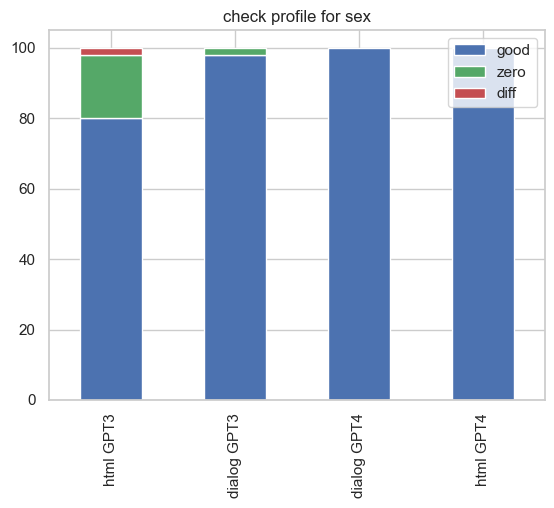

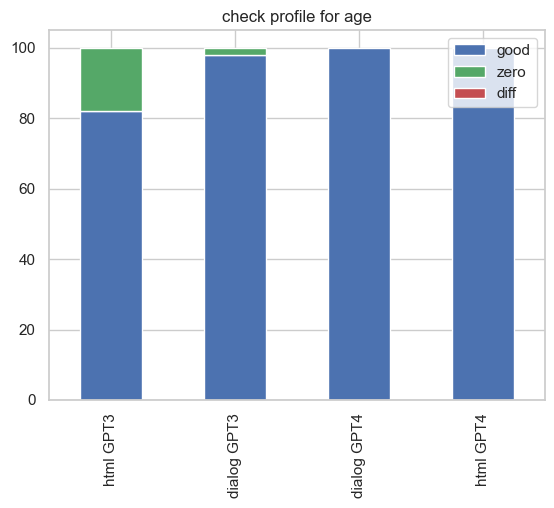

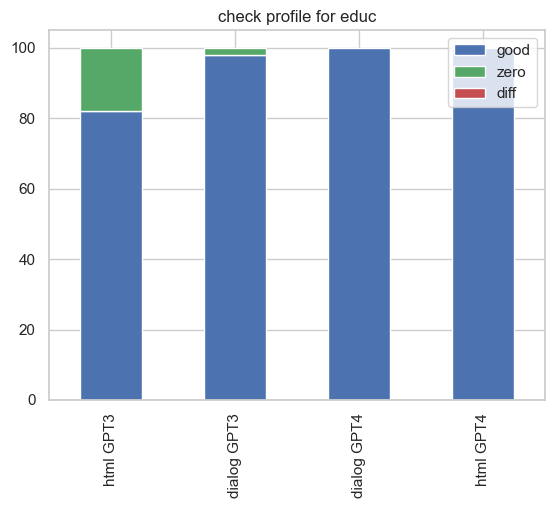

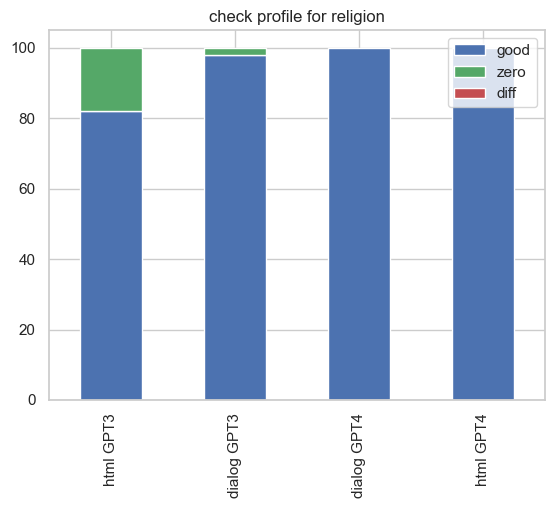

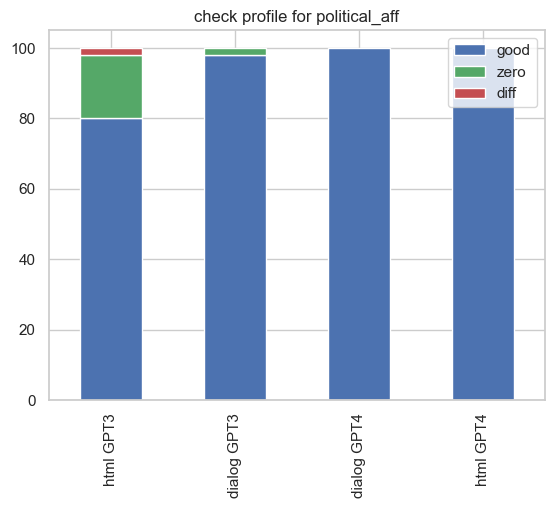

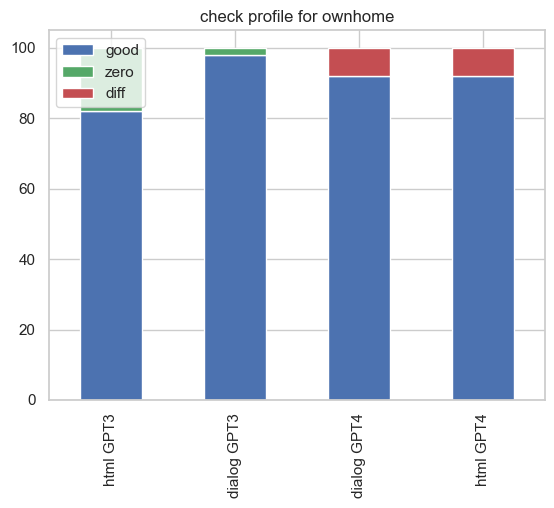

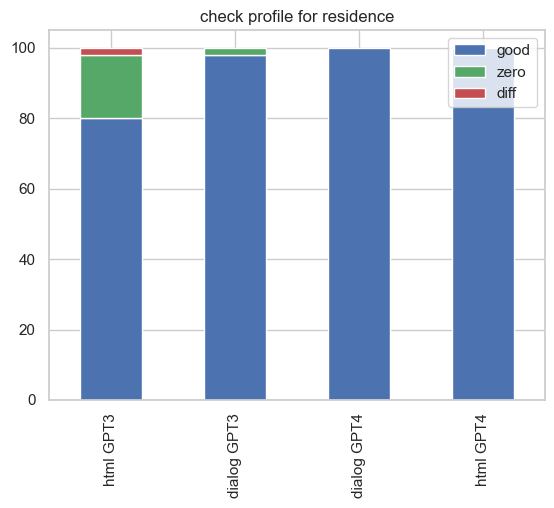

In [224]:

for c in res_all_col:
    col_res=res_all_col[c]

    by_field=pd.DataFrame.from_dict(col_res) / pd.DataFrame.from_dict(col_res).sum()*100
    by_field.columns=[ nice_session_label(c) for c in by_field.columns]
    by_field.transpose().plot.bar(stacked=True,color=['b','g','r'])
    
    plt.title(f"check profile for {c}")
    save_plot('check_profiles_'+c)
    plt.show()


In [225]:
res_all_col['ownhome'] 

{'til5ljad': {'good': 41, 'zero': 9, 'diff': 0},
 '27sypexp': {'good': 49, 'zero': 1, 'diff': 0},
 'a3ni6rrc': {'good': 46, 'zero': 0, 'diff': 4},
 'pvsds87k': {'good': 46, 'zero': 0, 'diff': 4}}

In [226]:
res_all_col['residence']

{'til5ljad': {'good': 40, 'zero': 9, 'diff': 1},
 '27sypexp': {'good': 49, 'zero': 1, 'diff': 0},
 'a3ni6rrc': {'good': 50, 'zero': 0, 'diff': 0},
 'pvsds87k': {'good': 50, 'zero': 0, 'diff': 0}}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sex [0.02, 0.0, 0.0, 0.0]
age [0.0, 0.0, 0.0, 0.0]
educ [0.0, 0.0, 0.0, 0.0]
religion [0.0, 0.0, 0.0, 0.0]
political_aff [0.02, 0.0, 0.0, 0.0]
ownhome [0.0, 0.0, 0.08, 0.08]
residence [0.02, 0.0, 0.0, 0.0]


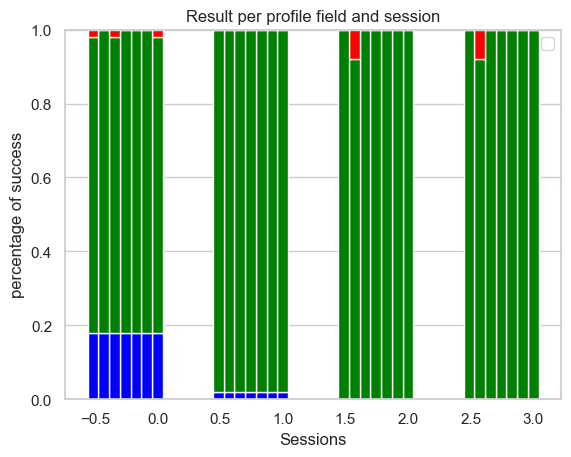

In [228]:
X_axis = np.arange(4) 
n= len(res_all_col)
wi = 1/n * .6
st = 0 
maxy = 0 
for j,c in res_all_col.items() :
    dgood = [d['good']/ (d['good']+d['diff']+d['zero']) for i,d in c.items()] 
    ddiff = [d['diff']/ (d['good']+d['diff']+d['zero']) for i,d in c.items()] 
    dzero = [d['zero']/ (d['good']+d['diff']+d['zero']) for i,d in c.items()]
    print(f'{j} {ddiff}')
    plt.bar(X_axis+st,dzero,width=wi,color='Blue')
    plt.bar(X_axis+st,dgood,  bottom=dzero,width=wi,color='Green')
    plt.bar(X_axis+st,ddiff,  bottom=[dzero[i] +dgood[i] for i in range (len(dzero)) ],width=wi,color='Red')
    st =st - wi
plt.xlabel("Sessions") 
plt.ylabel("percentage of success") 
plt.title("Result per profile field and session") 
plt.legend() 
plt.ylim((0,1))

plt.show()   

In [229]:
res_pct={}   
for j,c in res_all_col.items() :
    resl={}
    for i,d in c.items() : 
          resl[nice_session_label(i)] = d['good'] / ( d['good']+d['diff'])
    res_pct[j]=resl
res_pct=pd.DataFrame.from_dict(res_pct)
            
res_pct=res_pct.drop('no relig')

KeyError: "['no relig'] not found in axis"

In [ ]:
X_axis = np.arange(len(res_pct.index)) 
n= len(res_pct.columns)
wi = 1/n * .8
st = 0 
for c in res_pct.columns:

    plt.bar(X_axis+st,res_pct[c]*100,width=wi)
    st =st + wi
plt.xlabel("Sessions") 
plt.xticks(X_axis+.2, res_pct.index) 
plt.ylabel("percentage of success") 
plt.title("Result per profile field and session") 
plt.legend() 
plt.ylim((70,100))
save_plot('Success_profile'+c)
plt.show()          

In [ ]:
res_pct

,sex,age,educ,religion,political_aff,ownhome,residence
htlm0,0.989362,1.0,1.0,1.0,0.989362,0.978723,0.978723
html,0.988372,1.0,1.0,1.0,0.976744,0.976744,0.965116
dialog 0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
dialog,1.000000,1.0,1.0,1.0,0.989796,1.000000,1.000000


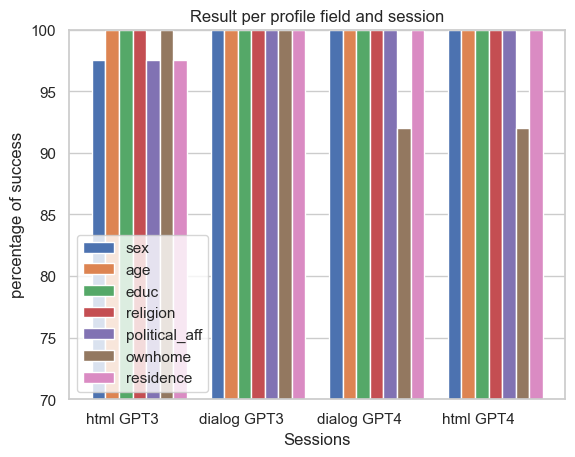

In [230]:
X_axis = np.arange(len(res_pct.index)) 
n= len(res_pct.columns)
wi = 1/n * .8
st = 0 
for c in res_pct.columns:

    plt.bar(X_axis+st,res_pct[c]*100,width=wi,label=c)
    st =st + wi
plt.xlabel("Sessions") 
plt.xticks(X_axis+.2, res_pct.index) 
plt.ylabel("percentage of success") 
plt.title("Result per profile field and session") 
plt.legend(loc=3) 
plt.ylim((70,100))
save_plot('Success_profile')
plt.show()          

In [ ]:
tab= pd.crosstab(index=all_app['id_in_session']-1, columns=all_app['session.code'],values=all_app['educ_num'],aggfunc='sum' )
tab['original']=original_df['educ']
tab.iloc[range(28,35)]

session.code,1hmmuoi7,5ckxhks0,ajsao22t,lrpes072,x21klci7,original
id_in_session,,,,,,
28,5.0,5.0,5.0,5.0,5.0,Post-grad
29,2.0,2.0,2.0,2.0,2.0,High school graduate
30,0.0,4.0,4.0,4.0,4.0,4-year
31,4.0,4.0,4.0,4.0,4.0,4-year
32,2.0,2.0,2.0,2.0,0.0,High school graduate
33,4.0,4.0,4.0,4.0,4.0,4-year
34,3.0,3.0,3.0,3.0,3.0,2-year


In [ ]:
tab= pd.crosstab(index=all_app['id_in_session']-1, columns=all_app['session.code'],values=all_app['educ'],aggfunc='sum' )
tab['original']=ref_profile_df['educ']
tab.iloc[range(28,35)]

session.code,1hmmuoi7,5ckxhks0,ajsao22t,lrpes072,x21klci7,original
id_in_session,,,,,,
28,5-Post graduate degree,5-Post graduate degree,5-Post graduate degree,5-Post graduate degree,5-Post graduate degree,Post-grad
29,2-High school graduate,2-High school graduate,2-High school graduate,2-High school graduate,2-High school graduate,High school graduate
30,0,4-College graduate,4-College graduate,4-College graduate,4-College graduate,4-year
31,4-College graduate,4-College graduate,4-College graduate,4-College graduate,4-College graduate,4-year
32,2-High school graduate,2-High school graduate,2-High school graduate,2-High school graduate,0,High school graduate
33,4-College graduate,4-College graduate,4-College graduate,4-College graduate,4-College graduate,4-year
34,3-Some college,3-Some college,3-Some college,3-Some college,3-Some college,2-year


In [ ]:
c='educ'
educ_tab = pd.DataFrame.from_dict([[v[1],ref_profile_df['educ'][v[0]-1],
                                    original_df['educ_num'][v[0]-1],
                                    str(original_df['educ_num'][v[0]-1])+'-'+ ref_profile_df['educ'][v[0]-1]  ]
                                    for i,v in  all_app[['id_in_session',c] ].iterrows()])
educ_tab.columns=['bot','orig','orig_num','label']
educ_tab

KeyError: 'educ_num'